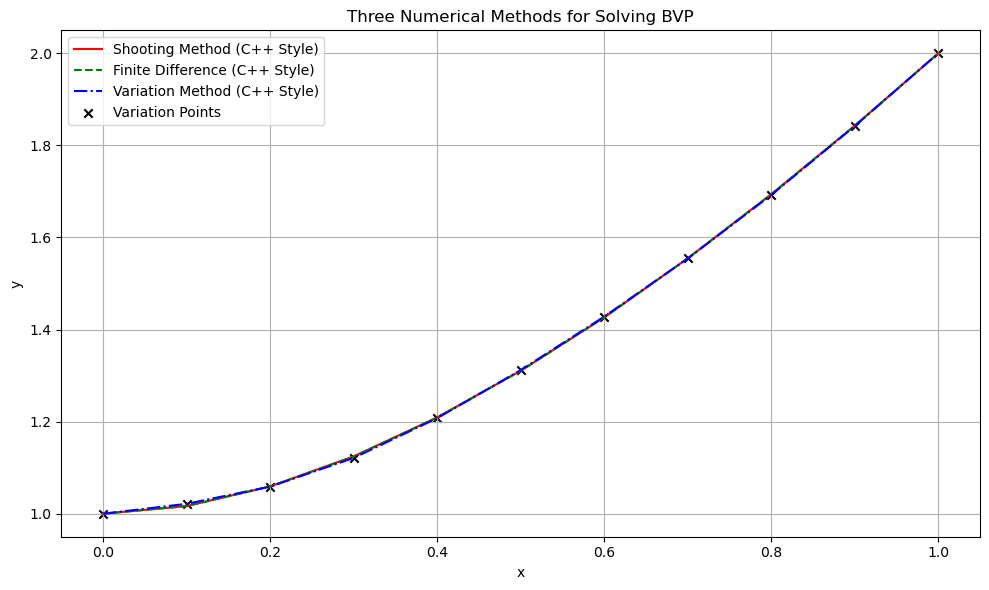

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# === 1. Finite Difference (C++ style) ===
def finite_difference_cpp_style():
    h = 0.1
    N = 10
    Y_LEFT, Y_RIGHT = 1.0, 2.0

    x = np.array([i * h for i in range(N + 1)])
    M = N - 1
    A = np.zeros((M, M))
    d = np.zeros(M)

    def rhs(x): return (1 - x**2) * np.exp(-x)

    for i in range(M):
        xi = x[i + 1]
        ai = 1.0 - (xi + 1) * h / 2.0
        bi = -2.0 - 2.0 * h**2
        ci = 1.0 + (xi + 1) * h / 2.0
        d[i] = h**2 * rhs(xi)

        if i == 0:
            A[i, i] = bi
            A[i, i + 1] = ci
            d[i] -= ai * Y_LEFT
        elif i == M - 1:
            A[i, i - 1] = ai
            A[i, i] = bi
            d[i] -= ci * Y_RIGHT
        else:
            A[i, i - 1] = ai
            A[i, i] = bi
            A[i, i + 1] = ci

    # Gaussian elimination
    for i in range(M - 1):
        factor = A[i + 1, i] / A[i, i]
        A[i + 1, i:] -= factor * A[i, i:]
        d[i + 1] -= factor * d[i]

    y_inner = np.zeros(M)
    y_inner[-1] = d[-1] / A[-1, -1]
    for i in range(M - 2, -1, -1):
        y_inner[i] = (d[i] - np.dot(A[i, i + 1:], y_inner[i + 1:])) / A[i, i]

    y = np.zeros(N + 1)
    y[0], y[-1] = Y_LEFT, Y_RIGHT
    y[1:N] = y_inner

    return x, y

# === 2. Shooting Method (C++ style Runge-Kutta) ===
def shooting_cpp_style():
    h = 0.1
    N = 10

    def f_1(x, y, dy): return -(x + 1) * dy + 2 * y + (1 - x**2) * np.exp(-x)
    def f_2(x, y, dy): return -(x + 1) * dy + 2 * y

    def rk4(y0, dy0, f):
        y, z, x = y0, dy0, 0.0
        y_out = []
        for _ in range(N + 1):
            y_out.append(y)

            k1 = h * z
            l1 = h * f(x, y, z)
            k2 = h * (z + l1 / 2)
            l2 = h * f(x + h / 2, y + k1 / 2, z + l1 / 2)
            k3 = h * (z + l2 / 2)
            l3 = h * f(x + h / 2, y + k2 / 2, z + l2 / 2)
            k4 = h * (z + l3)
            l4 = h * f(x + h, y + k3, z + l3)

            y += (k1 + 2 * k2 + 2 * k3 + k4) / 6
            z += (l1 + 2 * l2 + 2 * l3 + l4) / 6
            x += h

        return y_out

    y1 = rk4(1.0, 0.0, f_1)
    y2 = rk4(0.0, 1.0, f_2)
    c = (2.0 - y1[-1]) / y2[-1]
    y_final = [y1[i] + c * y2[i] for i in range(N + 1)]
    x_vals = [i * h for i in range(N + 1)]

    return x_vals, y_final

# === 3. Variation Method (Galerkin, sin basis) ===
def variation_cpp_style():
    PI = math.acos(-1)
    N_basis = 3
    M = 10000
    h = 1.0 / M

    def R(x): return (1 - x**2) * np.exp(-x) + (x + 1)
    def phi(i, x): return np.sin((i + 1) * PI * x)
    def dphi(i, x): return (i + 1) * PI * np.cos((i + 1) * PI * x)
    def ddphi(i, x): return -((i + 1) * PI)**2 * np.sin((i + 1) * PI * x)

    A = np.zeros((N_basis, N_basis))
    b = np.zeros(N_basis)

    for m in range(M + 1):
        x = m * h
        w = 0.5 if (m == 0 or m == M) else 1.0
        for j in range(N_basis):
            for i in range(N_basis):
                integrand = ddphi(i, x) * phi(j, x) + (x + 1) * dphi(i, x) * phi(j, x) - 2 * phi(i, x) * phi(j, x)
                A[j, i] += w * integrand * h
            b[j] += w * R(x) * phi(j, x) * h

    for i in range(N_basis):
        pivot = A[i, i]
        A[i, i:] /= pivot
        b[i] /= pivot
        for k in range(i + 1, N_basis):
            factor = A[k, i]
            A[k, i:] -= factor * A[i, i:]
            b[k] -= factor * b[i]

    c = np.zeros(N_basis)
    for i in reversed(range(N_basis)):
        c[i] = b[i] - np.dot(A[i, i + 1:], c[i + 1:])

    x_vals = np.linspace(0, 1, 11)
    y_vals = np.array([1 + x + sum(c[j] * np.sin((j + 1) * PI * x) for j in range(N_basis)) for x in x_vals])
    return x_vals, y_vals

# === Plotting ===
x_fd, y_fd = finite_difference_cpp_style()
x_shoot, y_shoot = shooting_cpp_style()
x_var, y_var = variation_cpp_style()

plt.figure(figsize=(10, 6))
plt.plot(x_shoot, y_shoot, 'r-', label='Shooting Method (C++ Style)')
plt.plot(x_fd, y_fd, 'g--', label='Finite Difference (C++ Style)')
plt.plot(x_var, y_var, 'b-.', label='Variation Method (C++ Style)')
plt.scatter(x_var, y_var, c='k', marker='x', label='Variation Points')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Three Numerical Methods for Solving BVP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import math

# 常數定義
h = 0.1
N = 10

# y'' = -(x+1)y' + 2y + (1 - x^2)e^{-x}
def f_1(x, y, dy):
    return -(x + 1) * dy + 2 * y + (1 - x * x) * math.exp(-x)

# y'' = -(x+1)y' + 2y
def f_2(x, y, dy):
    return -(x + 1) * dy + 2 * y

# Runge-Kutta method for y1 or y2
def RK4(y0, dy0, f):
    x = 0.0
    y = y0
    z = dy0

    y_out = []
    x_out = []

    for i in range(N + 1):
        y_out.append(y)
        x_out.append(x)

        k1 = h * z
        l1 = h * f(x, y, z)

        k2 = h * (z + l1 / 2)
        l2 = h * f(x + h / 2, y + k1 / 2, z + l1 / 2)

        k3 = h * (z + l2 / 2)
        l3 = h * f(x + h / 2, y + k2 / 2, z + l2 / 2)

        k4 = h * (z + l3)
        l4 = h * f(x + h, y + k3, z + l3)

        y += (k1 + 2 * k2 + 2 * k3 + k4) / 6
        z += (l1 + 2 * l2 + 2 * l3 + l4) / 6
        x += h

    return x_out, y_out

x, y1 = RK4(1.0, 0.0, f_1)

    # Solve y2'' = f_2 with y2(0)=0, y2'(0)=1
_, y2 = RK4(0.0, 1.0, f_2)

    # Calculate constant c
c = (2.0 - y1[-1]) / y2[-1]

print(f"c = {c:.6f}")
print("y(x) = y1(x) + c * y2(x):")
print("x\t\ty(x)")
for i in range(N + 1):
        y = y1[i] + c * y2[i]
        print(f"{x[i]:.1f}\t\t{y:.6f}")


c = 0.024157
y(x) = y1(x) + c * y2(x):
x		y(x)
0.0		1.000000
0.1		1.016650
0.2		1.059293
0.3		1.124476
0.4		1.209121
0.5		1.310528
0.6		1.426377
0.7		1.554712
0.8		1.693917
0.9		1.842688
1.0		2.000000


In [6]:
import math

# 常數設定
N = 10            # 區間數
h = 0.1           # 步長
Y_LEFT = 1.0      # y(0)
Y_RIGHT = 2.0     # y(1)

# 右端函數 r(x)
def rhs(x):
    return (1 - x * x) * math.exp(-x)

x = [i * h for i in range(N + 1)]

M = N - 1  # 未知數 y1~y9
A = [[0.0 for _ in range(M)] for _ in range(M)]
d = [0.0 for _ in range(M)]
y = [0.0 for _ in range(M)]

for i in range(M):
    xi = x[i + 1]
    ai = 1.0 - (xi + 1) * h / 2.0  # A_i
    bi = -2.0 - 2.0 * h * h        # B_i
    ci = 1.0 + (xi + 1) * h / 2.0  # C_i

    d[i] = h * h * rhs(xi)

    if i == 0:
        A[i][i] = bi
        A[i][i + 1] = ci
        d[i] -= ai * Y_LEFT
    elif i == M - 1:
        A[i][i - 1] = ai
        A[i][i] = bi
        d[i] -= ci * Y_RIGHT
    else:
        A[i][i - 1] = ai
        A[i][i] = bi
        A[i][i + 1] = ci

    # Gaussian elimination - forward elimination
for i in range(M - 1):
    factor = A[i + 1][i] / A[i][i]
    for j in range(i, M):
        A[i + 1][j] -= factor * A[i][j]
    d[i + 1] -= factor * d[i]

    # Back substitution
y[M - 1] = d[M - 1] / A[M - 1][M - 1]
for i in range(M - 2, -1, -1):
    sum_val = sum(A[i][j] * y[j] for j in range(i + 1, M))
    y[i] = (d[i] - sum_val) / A[i][i]

print(f"{'x':<8}{'y(x)':<12}")
print(f"{x[0]:<8.1f}{Y_LEFT:<12.6f}")
for i in range(1, N):
        print(f"{x[i]:<8.1f}{y[i - 1]:<12.6f}")
print(f"{x[N]:<8.1f}{Y_RIGHT:<12.6f}")

x       y(x)        
0.0     1.000000    
0.1     1.016532    
0.2     1.059102    
0.3     1.124251    
0.4     1.208890    
0.5     1.310313    
0.6     1.426194    
0.7     1.554570    
0.8     1.693822    
0.9     1.842642    
1.0     2.000000    


In [7]:
import math

PI = math.acos(-1.0)
N = 3         # basis functions: phi_1, phi_2, phi_3
M = 10000     # integration steps

# Right-hand side function R(x)
def R(x):
    return (1 - x * x) * math.exp(-x) + (x + 1)

# Basis function phi_i(x) = sin((i+1) * pi * x)
def phi(i, x):
    return math.sin((i + 1) * PI * x)

# phi_i'(x)
def dphi(i, x):
    return (i + 1) * PI * math.cos((i + 1) * PI * x)

# phi_i''(x)
def ddphi(i, x):
    return -((i + 1) * PI) ** 2 * math.sin((i + 1) * PI * x)

def variation_method():
    A = [[0.0 for _ in range(N)] for _ in range(N)]
    b = [0.0 for _ in range(N)]
    c = [0.0 for _ in range(N)]

    h = 1.0 / M
    for m in range(M + 1):
        x = m * h
        w = 0.5 if m == 0 or m == M else 1.0

        for j in range(N):
            for i in range(N):
                term = ddphi(i, x) * phi(j, x) + (x + 1) * dphi(i, x) * phi(j, x) - 2 * phi(i, x) * phi(j, x)
                A[j][i] += w * term * h
            b[j] += w * R(x) * phi(j, x) * h

    # Gaussian elimination
    for i in range(N):
        pivot = A[i][i]
        for j in range(i, N):
            A[i][j] /= pivot
        b[i] /= pivot

        for k in range(i + 1, N):
            factor = A[k][i]
            for j in range(i, N):
                A[k][j] -= factor * A[i][j]
            b[k] -= factor * b[i]

    # Back substitution
    for i in reversed(range(N)):
        c[i] = b[i]
        for j in range(i + 1, N):
            c[i] -= A[i][j] * c[j]

    # Output results
    print("(n = 3):")
    for i in range(N):
        print(f"c[{i + 1}] = {c[i]:.6f}")

    print("\nApproximate y(x) = 1 + x + sum(c_i * sin(i*pi*x)):")
    for m in range(11):
        x = m / 10.0
        y_val = 1 + x
        for i in range(N):
            y_val += c[i] * phi(i, x)
        print(f"x = {x:4.1f},\ty(x) = {y_val:.6f}")

# 執行變分法
variation_method()

(n = 3):
c[1] = -0.197122
c[2] = -0.017519
c[3] = -0.009060

Approximate y(x) = 1 + x + sum(c_i * sin(i*pi*x)):
x =  0.0,	y(x) = 1.000000
x =  0.1,	y(x) = 1.021459
x =  0.2,	y(x) = 1.058856
x =  0.3,	y(x) = 1.121064
x =  0.4,	y(x) = 1.207554
x =  0.5,	y(x) = 1.311938
x =  0.6,	y(x) = 1.428148
x =  0.7,	y(x) = 1.554387
x =  0.8,	y(x) = 1.692179
x =  0.9,	y(x) = 1.842053
x =  1.0,	y(x) = 2.000000
